In [1]:
from utils.visualizeGraph import draw_graph
from utils.getLLM import get_llm_embedings
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage,ToolMessage, SystemMessage, AnyMessage
from typing import Literal, Annotated
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnableMap
from langgraph.prebuilt import ToolNode, tools_condition
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.prebuilt.tool_node import Command


ModuleNotFoundError: No module named 'langchain_google_genai'

In [3]:
class OverallState(TypedDict):
    
    messages: Annotated[list[AnyMessage], add_messages]

    Interest_Charges_Tool: Annotated[list[AnyMessage], add_messages]

    Contact_Document_Tool: Annotated[list[AnyMessage], add_messages]

    General_Banking_Tool: Annotated[list[AnyMessage], add_messages]

    Bank_Details_Tool: Annotated[list[AnyMessage], add_messages]

    Appointment_Tool: Annotated[list[AnyMessage], add_messages]

    clean_output:str

    which_payload:str


In [4]:
class AssistantParser(BaseModel):   
    
    routes: Literal[ "to_routes","general"]

    class Config:
        json_schema_extra = {
            "example": {
                "routes": "to_routes"
            }
        }

def PrimaryAssistant(overall_state: OverallState) -> Command[Literal["Agent_Routers", "__end__"]]:

    print(">>>>>>>>>>>>>>>>>> PrimaryAssistant Running <<<<<<<<<<<<<<<<<<<<<<")

    llm = get_llm_embedings("open_ai")["llm"]

    template = """
                Note:
                You are Mukti Bhai, the chatbot for Muktinath Bikas Bank. Your role is to respond to user queries using only the context provided.

                - For banking-related questions, direct users to "to_routes."
                - For casual inquiries (e.g., "Hello", "How are you?", "What's your name?", "Good morning/afternoon", "Can you chat with me?", "Who are you?"), respond in a friendly, warm, and human-like manner.
                - For questions unrelated to banking or casual interactions, respond with: 
                
                "I am Mukti Bhai, Muktinath Bikas Bank's chatbot. I can only assist with banking-related topics."

                Here is the user's query:\n\n
                User query: {query}
                """

    llm_with_parser = llm.with_structured_output(AssistantParser)

    prompt = ChatPromptTemplate.from_template(template)
    
    chain = RunnableMap({"query": lambda x: x['question']}) | prompt | llm_with_parser

    result = chain.invoke({'question': overall_state['messages']})
    direction = result.routes

    if direction == "to_routes":
        return Command(
            goto="Agent_Routers"
        )
    else:
        # For general responses, without parsing the routes
        chain = RunnableMap({"query": lambda x: x['question']}) | prompt | llm
        result = chain.invoke({'question': overall_state['messages']})

        return Command(
            update={"clean_output": result, "which_payload": "none"},
            goto="__end__"
        )


In [5]:
def Agent_Routings(overall_state:OverallState):

    return {"messages": overall_state['messages']}

In [6]:
from tools.InterestRateTool import resultInterestRate
from tools.chargesTool import resultFeeCharges

def Interest_Charges_Handling_Agent(overall_state:OverallState):

    print(">>>>>>>>>>>>>>>>>> Interest_Charges_Handling_Agent Running <<<<<<<<<<<<<<<<<<<<<<")

    llm = get_llm_embedings("open_ai")["llm"]

    tools = [resultInterestRate, resultFeeCharges]

    llm_with_tools=llm.bind_tools(tools)

    template = """
        You are given with the tool resultInterestRate and resultFeeCharges. pick the correct tool according to the user 
        query and pass valid params to the tool.
        below is the user query: \n
        {query}

        Note:
        this is strict that you must call only one tool at a time. you are strtictly not allowed to call the tool
        more than oen
        """

    prompt = ChatPromptTemplate.from_template(template)

    chain = RunnableMap({"query": lambda x: x['question']}) | prompt | llm_with_tools
 
    result = chain.invoke({'question': overall_state['messages']})

    print(result)

    return {"Interest_Charges_Tool": result}


In [7]:
from tools.contactTool import resultBranchContact
from tools.documentTool import resultDocuments

def Contact_Document_Handling_Agent(overall_state:OverallState):

    print(">>>>>>>>>>>>>>>>>> Contact_Document_Handling_Agent Running <<<<<<<<<<<<<<<<<<<<<<")

    llm = get_llm_embedings("open_ai")["llm"]

    tools = [resultBranchContact, resultDocuments] 


    llm_with_tools=llm.bind_tools(tools)

    template = """
        You are given with the tool resultBranchContact and resultDocuments. pick the correct tool according to the user 
        query and pass valid params to the tool.
        below is the user query: \n
        {query}

         Note:
        If the user submits a query containing two questions, but your tool is not capable of handling both,
        call only the tool that can answer one of the questions. Do not attempt to call both tools if
        your tool is not designed to handle multiple questions at once. Only pass the parameters related 
        the question that your chosen tool can successfully process.
        """

    prompt = ChatPromptTemplate.from_template(template)

    chain = RunnableMap({"query": lambda x: x['question']}) | prompt | llm_with_tools
 
    result = chain.invoke({'question': overall_state['messages']})

    return {"Contact_Document_Tool": result}

  

In [8]:
from tools.generalBankingTool import generalBanking

def General_Banking_Handling_Agent(overall_state:OverallState):

    print(">>>>>>>>>>>>>>>>>> General_Banking_Handling_Agent Running <<<<<<<<<<<<<<<<<<<<<<")

    llm = get_llm_embedings("open_ai")["llm"]

    tools = [generalBanking]
   

    llm_with_tools=llm.bind_tools(tools)

    template = """
        You are given with the tool generalBanking. pick the correct tool according to the user 
        query and pass valid params to the tool.
        below is the user query: \n
        {query}

        Note:
        If the user submits a query containing two questions, but your tool is not capable of handling both,
        call only the tool that can answer one of the questions. Do not attempt to call both tools if
        your tool is not designed to handle multiple questions at once. Only pass the parameters related 
        the question that your chosen tool can successfully process.
        """

    prompt = ChatPromptTemplate.from_template(template)

    chain = RunnableMap({"query": lambda x: x['question']}) | prompt | llm_with_tools
 
    result = chain.invoke({'question': overall_state['messages']})

    return {"General_Banking_Tool": result}



In [9]:
from tools.bankDetailTool import bankDetailsTool

def Bank_Details_Handling_Agent(overall_state:OverallState):

    print(">>>>>>>>>>>>>>>>>> Bank_Details_Handling_Agent Running <<<<<<<<<<<<<<<<<<<<<<")

    llm = get_llm_embedings("open_ai")["llm"]

    tools = [bankDetailsTool]

    llm_with_tools=llm.bind_tools(tools)

    template = """
        You are given with the tool bankDetailsTool. pick the correct tool according to the user 
        query and pass valid params to the tool.
        below is the user query: \n
        {query}

         Note:
        If the user submits a query containing two questions, but your tool is not capable of handling both,
        call only the tool that can answer one of the questions. Do not attempt to call both tools if
        your tool is not designed to handle multiple questions at once. Only pass the parameters related 
        the question that your chosen tool can successfully process.
        """

    prompt = ChatPromptTemplate.from_template(template)

    chain = RunnableMap({"query": lambda x: x['question']}) | prompt | llm_with_tools
 
    result = chain.invoke({'question': overall_state['messages']})

    return {"Bank_Details_Tool": result}


In [10]:
from tools.appointmentTool import resultAppointment

def Appointment_Handling_Agent(overall_state:OverallState):

    print(">>>>>>>>>>>>>>>>>> Appointment_Handling_Agent Running <<<<<<<<<<<<<<<<<<<<<<")

    llm = get_llm_embedings("open_ai")["llm"]

    tools = [resultAppointment]

    llm_with_tools=llm.bind_tools(tools)

    template = """
        You are given with the tool resultAppointment. pick the correct tool according to the user 
        query and pass valid params to the tool.
        below is the user query: \n
        {query}

         Note:
        If the user submits a query containing two questions, but your tool is not capable of handling both,
        call only the tool that can answer one of the questions. Do not attempt to call both tools if
        your tool is not designed to handle multiple questions at once. Only pass the parameters related 
        the question that your chosen tool can successfully process.
        """

    prompt = ChatPromptTemplate.from_template(template)

    chain = RunnableMap({"query": lambda x: x['question']}) | prompt | llm_with_tools
 
    result = chain.invoke({'question': overall_state['messages']})

    return {"Appointment_Tool": result}



Tools

In [11]:
# def toolOrend(overall_state: OverallState):
#     messages = next((overall_state[tool] for tool in [
#         "Interest_Charges_Tool", "Contact_Document_Tool", 
#         "General_Banking_Tool", "Bank_Details_Tool", 
#         "Appointment_Tool"] if overall_state[tool]), None)

#     # Ensure that messages is not an empty list
#     if messages:
#         last_message = messages[-1]
#         if last_message.tool_calls:
#             return "tools"
#     return "end_it"

def toolOrend(overall_state: OverallState):
    messages = (overall_state["Interest_Charges_Tool"] if overall_state["Interest_Charges_Tool"] else
                overall_state["Contact_Document_Tool"] if overall_state["Contact_Document_Tool"] else
                overall_state["General_Banking_Tool"] if overall_state["General_Banking_Tool"] else
                overall_state["Bank_Details_Tool"] if overall_state["Bank_Details_Tool"] else
                overall_state["Appointment_Tool"])

    if messages and messages[-1].tool_calls:
        return "tools"
    return "end_it"



In [ ]:
def getClearContext(agents,state):
    all_agent_context = ""
    for state_key in agents:
        list_of_messages=(state[state_key])
        for i in  list_of_messages:
            all_agent_context +=i.content+", "
    return (all_agent_context.replace(".",""))


class PayLoadParser(BaseModel):   
    
    payLoad_Type: Literal['live_agent', 'appointment', 'complain', 'feedback', 'none'] = Field(description="""
    this column may only contains values from the list ['live_agent', 'appointment', 'complain', 'feedback', 'none']
""")

    class Config:
        json_schema_extra = {
            "example": {
                "payLoad_Type": "appointment"
            }
        }

def Answer_Handling_Agent(overall_state:OverallState):

    print(">>>>>>>>>>>>>>>>>> Answer_Handling_Agent Running <<<<<<<<<<<<<<<<<<<<<<")

    llm = get_llm_embedings("open_ai")["llm"]

    template = """
                You are given a user query and context. Your task is to answer the user query using only the information provided in the context. 
                Ensure that your answer is strictly related to the context and avoid making any assumptions or adding extra information. 
                if the user query is not in the context then you for that information please contact with the bank.

                User Query:
                {query}

                Context:
                {context}

                """
    
    payload_template = """ 
        You are the classifier who identifies the user's question and its answer. 
        You are given the question and answer. By analyzing the question, tell me if it's related to 
        'live_agent', 'appointment', 'complain', 'feedback', or 'none'.
        If the user is asking for an appointment or the application process, put `payLoad_Type` as 'appointment'.
        If the user is asking for a complaint, put `payLoad_Type` as 'complain'.
        If the user is asking for feedback, put `payLoad_Type` as 'feedback'.
        If the user is asking for a live agent, put `payLoad_Type` as 'live_agent'.
        If the user wants to talk with a live person in the bank, then put `payLoad_Type` as 'live agent'.
        If the user is not asking for any of the above, then put 'none'. \n\n

        Here is the user query: {query}\n\n

        Here is the answer: {answer}
        
        """
    
    agents = list(overall_state.keys())[:-6:-1]

    contexts = getClearContext(agents,overall_state)

    prompt = ChatPromptTemplate.from_template(template)

    chain = RunnableMap({"query": lambda x: x['question'],
                         "context": lambda x: contexts}) | prompt | llm

    result = chain.invoke({'question': overall_state['messages']})

    llm_with_parser = llm.with_structured_output(PayLoadParser)

    payload_prompt = ChatPromptTemplate.from_template(payload_template)

    payload_chain = RunnableMap({"query": lambda x: x['question'],
                         "answer": lambda x: x['clean_output']}) | payload_prompt | llm_with_parser
    
    print("paylpoad chain",payload_chain)

    payload_result = payload_chain.invoke({'question': overall_state['messages'], 'clean_output': result})

    payload_result = payload_result.payLoad_Type

    print("payload_result: ",payload_result)

    return {"clean_output": result,"which_payload": payload_result}


NameError: name 'BaseModel' is not defined

In [ ]:
graph_builder = StateGraph(OverallState)

# Add the primary assistant node
graph_builder.add_node("primary_assistant", PrimaryAssistant)

# Add the edge from START to Agent_Routers
graph_builder.add_edge(START, "primary_assistant")

# router
graph_builder.add_node("Agent_Routers", Agent_Routings)

# Add all the specialized agent nodes
graph_builder.add_node("Interest_Charges_Handling_Agent", Interest_Charges_Handling_Agent)
graph_builder.add_node("Contact_Document_Handling_Agent", Contact_Document_Handling_Agent)
graph_builder.add_node("General_Banking_Handling_Agent", General_Banking_Handling_Agent)
graph_builder.add_node("Bank_Details_Handling_Agent", Bank_Details_Handling_Agent)
graph_builder.add_node("Appointment_Handling_Agent", Appointment_Handling_Agent)
graph_builder.add_node("Answer_Handling_Agent", Answer_Handling_Agent)


# Connect Agent_Routers to all specialized agents
graph_builder.add_edge("Agent_Routers", "Interest_Charges_Handling_Agent")
graph_builder.add_edge("Agent_Routers", "Contact_Document_Handling_Agent")
graph_builder.add_edge("Agent_Routers", "General_Banking_Handling_Agent")
graph_builder.add_edge("Agent_Routers", "Bank_Details_Handling_Agent")
graph_builder.add_edge("Agent_Routers", "Appointment_Handling_Agent")

#tool node
graph_builder.add_node("Interest_Charges_tool",ToolNode([resultInterestRate, resultFeeCharges],messages_key="Interest_Charges_Tool"))
graph_builder.add_node("Contact_Document_tool",ToolNode([resultBranchContact, resultDocuments],messages_key="Contact_Document_Tool"))
graph_builder.add_node("General_Banking_tool",ToolNode([generalBanking],messages_key="General_Banking_Tool"))
graph_builder.add_node("Bank_Details_tool",ToolNode([bankDetailsTool],messages_key="Bank_Details_Tool"))
graph_builder.add_node("Appointment_tool",ToolNode([resultAppointment],messages_key="Appointment_Tool"))


graph_builder.add_conditional_edges("Interest_Charges_Handling_Agent",toolOrend,{"tools": "Interest_Charges_tool","end_it":END})
graph_builder.add_conditional_edges("Contact_Document_Handling_Agent",toolOrend,{"tools": "Contact_Document_tool","end_it":END})
graph_builder.add_conditional_edges("General_Banking_Handling_Agent",toolOrend,{"tools": "General_Banking_tool","end_it":END})
graph_builder.add_conditional_edges("Bank_Details_Handling_Agent",toolOrend,{"tools": "Bank_Details_tool","end_it":END})
graph_builder.add_conditional_edges("Appointment_Handling_Agent",toolOrend,{"tools": "Appointment_tool","end_it":END})


graph_builder.add_edge("Interest_Charges_tool", "Answer_Handling_Agent")
graph_builder.add_edge("Contact_Document_tool", "Answer_Handling_Agent")
graph_builder.add_edge("General_Banking_tool", "Answer_Handling_Agent")
graph_builder.add_edge("Bank_Details_tool", "Answer_Handling_Agent")
graph_builder.add_edge("Appointment_tool", "Answer_Handling_Agent")
graph_builder.add_edge("Answer_Handling_Agent", END)


# Compile the graph
graph = graph_builder.compile()

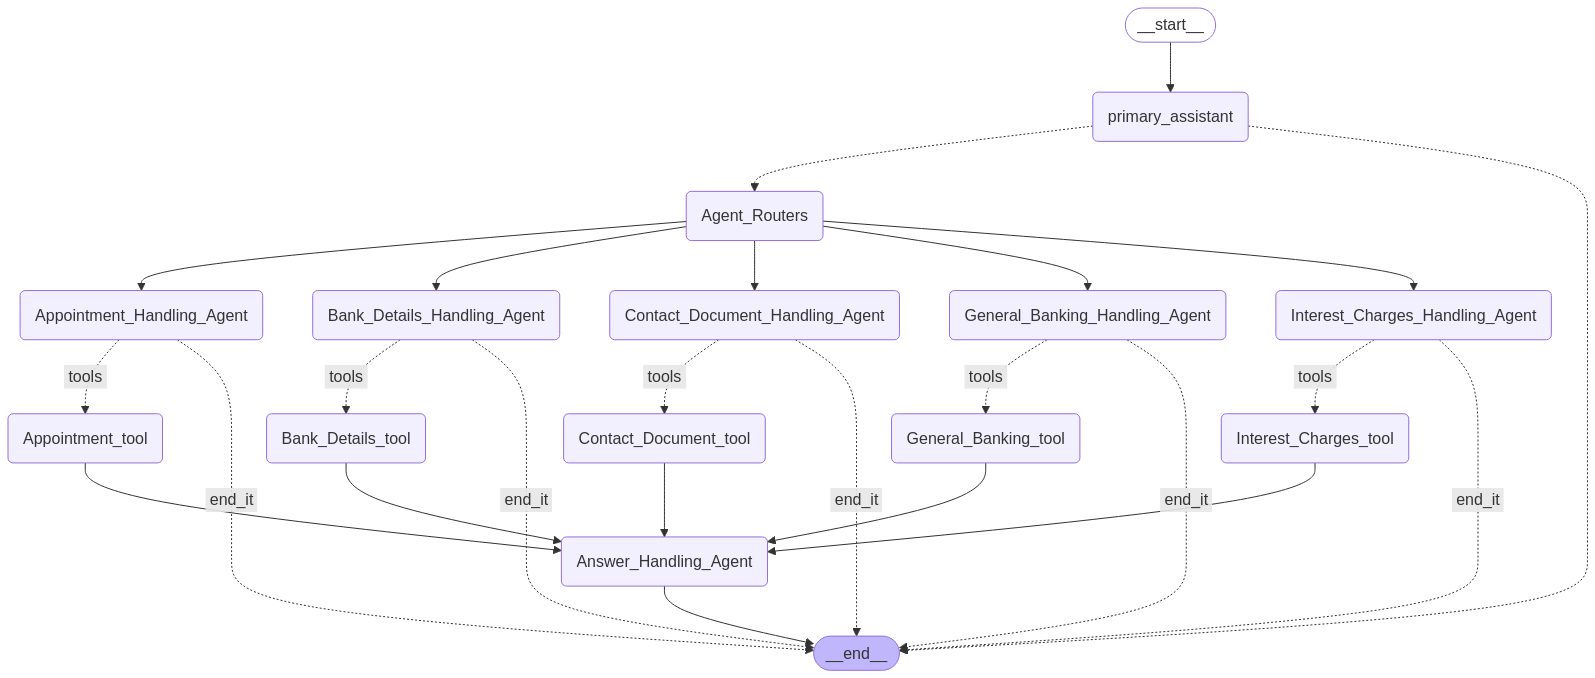

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
m = graph.invoke({"messages":[HumanMessage(content="hello")]})

>>>>>>>>>>>>>>>>>> PrimaryAssistant Running <<<<<<<<<<<<<<<<<<<<<<


In [ ]:
m

{'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='75d6e56f-1b4c-4aa8-a98d-862c4189fc77')],
 'Interest_Charges_Tool': [],
 'Contact_Document_Tool': [],
 'General_Banking_Tool': [],
 'Bank_Details_Tool': [],
 'Appointment_Tool': [],
 'clean_output': AIMessage(content='Hello! 😊 How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 209, 'total_tokens': 220, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e4fa3702df', 'finish_reason': 'stop', 'logprobs': None}, id='run-92d9733b-f4c6-4ad9-aea6-9e28709c81ae-0', usage_metadata={'input_tokens': 209, 'output_tokens': 11, 'total_tokens': 220, 'input_token_details': {'audio': 0, 'cache_read': 0}, '

live agent - if all are none <br>
appointmet tool huda <br>
complain <br>
feedback